In [1]:
import sys
import os
import numpy as np
import xarray as xr
from glob import glob
import matplotlib.pyplot as plt
import warnings
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle
import metpy.calc as mpc
from metpy.units import units
# for animations
from PIL import Image

In [2]:
warnings.filterwarnings('ignore')

In [3]:
# aggregation indices
os.chdir('/data2/willytsai/python_module')
import conorgidx_revise as agi
from SCAI_calc4obj import labeled_obj, SCAI_calc
from COP_calc4obj import COP
from MICA_calc4obj import MICA

In [4]:
def running_mean(y,window_N):
    y_avg = np.zeros(len(y))
    avg_mask = np.ones(window_N) / window_N

    y_avg = np.convolve(y, avg_mask, 'same')
    y_avg[-window_N:] = y[-window_N:]
    y_avg[:window_N] = y[:window_N]
    return y_avg    

In [5]:
def lanczos_filter(data_1d,dx=2,a=10):
    "simple Lanczos filter, a = Lanczos parameter \
     for example, a = 3 means kernel damped to zero at +-3"
    
    data_filtered = np.copy(data_1d)
    # generating Lanczos function
    L = np.sinc(np.arange(-a,a+1))*np.sinc(np.arange(-a,a+1)/a)
        
    for x in range(len(data_1d)):
        data_filtered[x] = np.sum(data_1d[x-a:x+a+1]*L)
    
    return data_filtered

In [6]:
# a=3
# L = np.zeros(50)
# for n,x in enumerate(np.linspace(-a,a,50)):
#     L[n] = a*np.sin(np.pi*x)*np.sin(np.pi*x/a)/((np.pi**2)*(x**2))
#     if x == 0:
#         L[n] = 1
# plt.plot(np.linspace(-a,a,50),L)

In [7]:
def read_data(data_dir,t_start=0,t_end=1081):
    os.chdir(data_dir)
    print(data_dir)
    file_name = glob('*nc')
    data_zon = xr.open_dataset('cm1out_zonmean.nc')
    data_3d = xr.open_dataset('cm1out_sub3d.nc')
    data_2d = xr.open_dataset('cm1out_2Dvars.nc')
    data_q3d = xr.open_dataset('cm1out_q3d.nc')
    
    #3d data
    th3d = data_3d.th[t_start:t_end,:45,:,:]
    v3d = data_3d.vinterp[t_start:t_end,:45,:,:]
    u3d = data_3d.uinterp[t_start:t_end,:45,:,:]
    w3d = data_3d.winterp[t_start:t_end,:45,:,:]
    qc3d = data_q3d.qc[t_start:t_end,:45,:,:]
    qi3d = data_q3d.qi[t_start:t_end,:45,:,:]
    qr3d = data_q3d.qr[t_start:t_end,:45,:,:]
    qg3d = data_q3d.qg[t_start:t_end,:45,:,:]
    qs3d = data_q3d.qs[t_start:t_end,:45,:,:]
    
    rnp3d = (qc3d+qi3d)
    rp3d = (qr3d+qg3d+qs3d)
    
    # zonal mean data
    th = data_zon.th[t_start:t_end,:,:,:]
    qv = data_zon.qv[t_start:t_end,:,:,:]
#     u = data_zon.uinterp[t_start:t_end,:,:,:]
#     v = data_zon.vinterp[t_start:t_end,:,:,:]
#     w = data_zon.winterp[t_start:t_end,:,:,:]
    qc = data_zon.qc[t_start:t_end,:,:,:]
    qi = data_zon.qi[t_start:t_end,:,:,:]
    prs = data_zon.prs[t_start:t_end,:,:,:]
    # 2d data
    prate = data_2d.prate[t_start:t_end,:,:]
    pwat = data_2d.pwat[t_start:t_end,:,:]
    cwp = data_2d.cwp[t_start:t_end,:,:]
    cape = data_2d.cape[t_start:t_end,:,:]
    cin = data_2d.cin[t_start:t_end,:,:]
    
    # temperature conversion
    T = th/((1000*100/prs)**(287.15/1004))-273.15 # [degC]
    # density 
    ro = prs/(287.15*(T+273.15))

    x_dim = data_2d.lon
    y_dim = data_2d.lat
#    div = np.gradient(v,y_dim*1000,axis=2) # du/dx+dv/dy 
#    vor = -np.gradient(u,y_dim*1000,axis=2) # -du/dy+dv/dx
    #relative humidty calculation, Buck (1996)
    es_liq = 0.61121*np.exp((18.678-T/234.5)*(T/(257.14+T)))*10 #[hpa]
    es_ice = 0.61115*np.exp((23.036-T/333.7)*(T/(279.82+T)))*10

    qs_liq = 0.622*es_liq/(prs/100-es_liq)
    qs_ice = 0.622*es_ice/(prs/100-es_ice)

    rh = qv/qs_liq
    rh_ice = qv/qs_ice

    rh = rh.values.flatten()
    rh_ice = rh_ice.values.flatten()
    T_test = T.values.flatten()

    rh[T_test<0] = rh_ice[T_test<0]
    rh = rh.reshape((T.shape[0],T.shape[1],T.shape[2],T.shape[3]))
    rh = xr.DataArray(rh,coords=[T.time,T.lev,T.lat,T.lon],dims=['time','lev','lat','lon'])
    
#    return (th,T,qv,qc,qi,rh,prate*3600*24,pwat*1000,cwp,u,v,w,div,vor,cape,cin,prs,ro,th3d,v3d,u3d)
    return (th,T,qv,qc,qi,rh,prate*3600*24,pwat*1000,cwp,u3d,v3d,w3d,cape,cin,prs,ro,th3d,rp3d,rnp3d)

In [8]:
# get weather or weather2 
server = '/data2/willytsai/cm1r19.8/analysis/runs_cheyenne/'
exp_name = ['CM1_RAD4K_RCEP_240x240_lowU15']
exp_short = ['CTRL','U10']

#os.chdir(server)
#os.system('mkdir -p fig_sum') # create a figure archive
#fig_dir = server+'fig_sum/' 

In [9]:
(th1,T1,qv1,qc1,qi1,rh1,prate1,pwat1,cwp1,u3d1,v3d1,w3d1,cape1,cin1,prs1,ro1,th3d1,rp3d1,rnp3d1) = read_data(server+exp_name[0],
                                                                                                   t_start=360,t_end=721)

/data2/willytsai/cm1r19.8/analysis/runs_cheyenne/CM1_RAD4K_RCEP_240x240_lowU15


In [10]:
x_dim = pwat1.lon
y_dim = pwat1.lat
z_dim = T1.lev
t_dim = np.arange(len(T1.time))/3

In [13]:
data_ctr = xr.open_dataset('/data2/willytsai/cm1r19.8/analysis/runs_cheyenne/CM1_RAD4K_MPI_SFXint/cm1out_sub3d.nc')
th3d_ctr = data_ctr.th

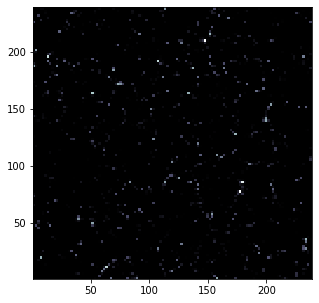

In [19]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
t = -22
cp = (th3d1[t,0,:,:]-th3d1[t,0,:,:].mean(('lat','lon'))).values
#cp[cp>-1] = 0                                     
plt.pcolormesh(th3d1.lon,th3d1.lat,cp,
            cmap='bone')
#plt.colorbar()

In [ ]:
# cold pool stats - size, number
# time-series of size, number

In [21]:
def lag_coeff(x):
    "x is a 1d array"
    coeff = np.empty(x.size)
    for lag in range(x.size):
        coeff[lag] = np.corrcoef(x,np.roll(x,lag))[0,1] # return lag coefficient
    return coeff

In [26]:
auto_coeff_ctr = np.empty((360,120))
cwp_sub = cwp_ctr[-360:,:,:]
cwp_yt = cwp_sub.mean(axis=2)

for t in range(360):
    auto_coeff_ctr[t,:] = lag_coeff(cwp_yt[t,:])

auto_coeff_s = np.empty((len(exp_name),360,120))
auto_coeff_ns = np.copy(auto_coeff_s)
    
for n,cwp in enumerate([cwp1]):

    cwp_sub = cwp[-360:,:,:]
    cwp_yt = cwp_sub.mean(axis=2)
    cwp_yt_s = cwp_yt[:,60:180]
    cwp_yt_ns =  np.concatenate([cwp_yt[:,-60:],cwp_yt[:,:60]],axis=1)

    for t in range(360):
        auto_coeff_s[n,t,:] = lag_coeff(cwp_yt_s[t,:])
        auto_coeff_ns[n,t,:] = lag_coeff(cwp_yt_ns[t,:])

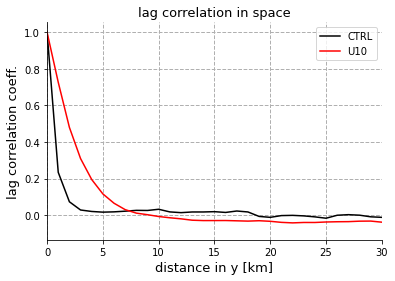

In [27]:
fig,ax = plt.subplots(1,1,figsize=(6,4))
colors = ['r']

ax.plot(auto_coeff_ctr[:,:].mean(axis=0),'-',color='k')
for n in range(len(exp_name)):
    ax.plot(auto_coeff_s[n,:,:].mean(axis=0),'-',color=colors[n])

ax.legend(exp_short)
ax.set_xlim([0,30])
#ax.set_xticks(ticks=[0,3,6,9,12,15,18,21]);ax.set_xticklabels([0,6,12,18,24,30,36,42])
ax.set_xlabel('distance in y [km]',fontsize=13)
ax.set_ylabel('lag correlation coeff.',fontsize=13)
ax.set_title('lag correlation in space',fontsize=13)
ax.grid(linestyle='--',linewidth=1)#;ax.set_ylim([-0.2,1.1])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#fig.savefig(fig_dir+'lag_coeff_thvariance_space.pdf',bbox_inches='tight',transparent=False)

In [31]:
# correlation in time
auto_coeff_ctr_t = np.empty((360,120))
cwp = cwp_ctr[-360:,:,:]
cwp_yt = cwp.mean(axis=2)
for y in range(120):
    auto_coeff_ctr_t[:,y] = lag_coeff(cwp_yt[:,y])

# autocorrelation in time
auto_coeff_s_t = np.empty((len(exp_name),360,120))
auto_coeff_ns_t = np.copy(auto_coeff_s_t)

for n,cwp in enumerate([cwp1]):

    cwp_sub = cwp[-360:,:,:]
    cwp_yt = cwp_sub.mean(axis=2)
    cwp_yt_s = cwp_yt[:,60:180]
    cwp_yt_ns =  np.concatenate([cwp_yt[:,-60:],cwp_yt[:,:60]],axis=1)
      
    for y in range(120):
        auto_coeff_s_t[n,:,y] = lag_coeff(cwp_yt_s[:,y])
        auto_coeff_ns_t[n,:,y] = lag_coeff(cwp_yt_ns[:,y])

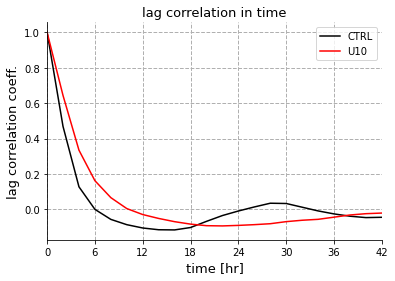

In [32]:
fig,ax = plt.subplots(1,1,figsize=(6,4))
colors = ['r']

ax.plot(auto_coeff_ctr_t[:,:].mean(axis=1),'-',color='k')
for n in range(len(exp_name)):
    ax.plot(auto_coeff_s_t[n,:,:].mean(axis=1),'-',color=colors[n])
    
ax.legend(exp_short)
ax.set_xlim([0,21])
ax.set_xticks(ticks=[0,3,6,9,12,15,18,21]);ax.set_xticklabels([0,6,12,18,24,30,36,42])
ax.set_xlabel('time [hr]',fontsize=13)
ax.set_ylabel('lag correlation coeff.',fontsize=13)
ax.set_title('lag correlation in time',fontsize=13)
ax.grid(linestyle='--',linewidth=1)#;ax.set_ylim([-0.2,1.1])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#fig.savefig(fig_dir+'lag_coeff_thvariance_space.pdf',bbox_inches='tight',transparent=False)

In [ ]:
os.chdir(server + exp_name[0]) # experiment directory
os.system('mkdir -p data_out')
os.chdir(server + exp_name[0] + '/data_out')

# save data array for later 
np.save('autocorre_space_shear_yz.npy',auto_coeff_s)
np.save('autocorre_space_unshear_yz.npy',auto_coeff_ns)
np.save('autocorre_time_shear_yz.npy',auto_coeff_s_t)
np.save('autocorre_time_unshear_yz.npy',auto_coeff_ns_t)

In [ ]:
# # save control data array for later
# os.chdir(server + 'CM1_RAD4K_MPI_SFXint') # experiment directory
# np.save('autocorre_space_shear_yz.npy',auto_coeff_ctr)
# np.save('autocorre_space_unshear_yz.npy',auto_coeff_ctr)
# np.save('autocorre_time_shear_yz.npy',auto_coeff_ctr_t)
# np.save('autocorre_time_unshear_yz.npy',auto_coeff_ctr_t)

### Diagnosis section for existing outputs

In [ ]:
# combine all outputs
server = '/data2/willytsai/cm1r19.8/analysis/runs_cheyenne/'
exp_name = ['CM1_RAD4K_MPI_SFXint',
            'CM1_RAD4K_RCEP_240x240_lowU05',
            'CM1_RAD4K_RCEP_240x240_lowU10',
            'CM1_RAD4K_RCEP_240x240_lowU15']

In [ ]:
fig,ax = plt.subplots(len(exp_name),1,figsize=(12,2*len(exp_name)))

for n,exp in enumerate(exp_name):
    data = xr.open_dataset(server+exp+'/cm1out_sub3d.nc')
    th = data.th
    cp = (th[-360:,0,:,:]-th[-360:,0,:,:].mean(('lat','lon'))).values
    cp[cp>-1] = 0      
    tt = np.arange(360)
    yy = th.lat
    if n == 0:
        cf = ax[n].pcolormesh(tt,yy,np.nanmean(cp,axis=2).T,
                     cmap='bone',vmin=-2,vmax=0)
    else:
        cf = ax[n].pcolormesh(tt,yy[60:180],np.nanmean(cp[:,60:180,:],axis=2).T,
                     cmap='bone',vmin=-2,vmax=0)
    plt.colorbar(cf,ax=ax[n])

In [ ]:
fig,ax = plt.subplots(len(exp_name),1,figsize=(12,2*len(exp_name)))

for n,exp in enumerate(exp_name):
    data2 = xr.open_dataset(server+exp+'/cm1out_2Dvars.nc')
    cwp = data2.cwp
    cwp = cwp[-360:,:,:]
    tt = np.arange(360)
    yy = cwp.lat
    if n == 0:
        cf = ax[n].pcolormesh(tt,yy,np.nanmean(cwp,axis=2).T,
                     cmap='bone',vmin=0,vmax=0.3)
    else:
        cf = ax[n].pcolormesh(tt,yy[60:180],np.nanmean(cwp[:,60:180,:],axis=2).T,
                     cmap='bone',vmin=0,vmax=0.3)
    plt.colorbar(cf,ax=ax[n])

In [ ]:
tmp = np.load(server+exp_name[0]+'/data_out/autocorre_space_shear_yz.npy')
timesteps = len(tmp)

corr_space_s_all = np.zeros((len(exp_name),120))
corr_space_ns_all = np.zeros((len(exp_name),120))
corr_time_s_all = np.zeros((len(exp_name),timesteps))
corr_time_ns_all = np.zeros((len(exp_name),timesteps))

for n in range(len(exp_name)):
    corr_space_s_all[n,:] = np.mean(np.load(server+exp_name[n]+'/data_out/autocorre_space_shear_yz.npy').squeeze(),axis=0)
    corr_space_ns_all[n,:] = np.mean(np.load(server+exp_name[n]+'/data_out/autocorre_space_unshear_yz.npy').squeeze(),axis=0)

    corr_time_s_all[n,:] = np.mean(np.load(server+exp_name[n]+'/data_out/autocorre_time_shear_yz.npy').squeeze(),axis=1)
    corr_time_ns_all[n,:] = np.mean(np.load(server+exp_name[n]+'/data_out/autocorre_time_unshear_yz.npy').squeeze(),axis=1)

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(6,4))
colors = ['k','r','g','b']

for n in range(len(exp_name)):
    ax.plot(corr_space_s_all[n,:],'-',color=colors[n],label=exp_name[n])
    
ax.legend()
ax.set_xlim([0,21])
ax.set_xticks(ticks=[0,3,6,9,12,15,18,21]);ax.set_xticklabels([0,6,12,18,24,30,36,42])
ax.set_xlabel('distance [km]',fontsize=13)
ax.set_ylabel('lag correlation coeff.',fontsize=13)
ax.set_title('lag correlation in space',fontsize=13)
ax.grid(linestyle='--',linewidth=1)#;ax.set_ylim([-0.2,1.1])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(6,4))
colors = ['k','r','g','b']

for n in range(len(exp_name)):
    ax.plot(corr_time_s_all[n,:],'-',color=colors[n],label=exp_name[n])
    
ax.legend()
ax.set_xlim([0,21])
ax.set_xticks(ticks=[0,3,6,9,12,15,18,21]);ax.set_xticklabels([0,1,2,3,4,5,6,7])
ax.set_xlabel('time [hr]',fontsize=13)
ax.set_ylabel('lag correlation coeff.',fontsize=13)
ax.set_title('lag correlation in time',fontsize=13)
ax.grid(linestyle='--',linewidth=1)#;ax.set_ylim([-0.2,1.1])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)